# Basic Model Training

## Aims
* Using the `compound_rings` data and associated images to train a basic model 
* Perform some error analysis and improve the model 
* Log the results of the experiments as well as the models output ready for deployment

## Notes 
Please read the markdown throughout to continue the MLOps demo.

In [1]:
import numpy as np
import mlflow
import pandas as pd 
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

2021-09-19 10:01:36.040597: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-19 10:01:36.040646: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Setup
Any parameters are set up here.

In [2]:
model_version = "v1"
image_size = (300, 300)

In [3]:
experiment_id = mlflow.create_experiment("Predict Rings")

In [4]:
mlflow.end_run()
mlflow.start_run(run_name="v1", experiment_id=experiment_id)

2021/09/19 10:01:38 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



<ActiveRun: >

In [5]:
mlflow.log_param("version", model_version)
mlflow.log_param("image_size", image_size)

## Load Data
Load the csv and build the training data set. 

In [6]:
compound_df = pd.read_csv("data/compound_rings.csv")
display(compound_df)

,compound_id,num_rings,image
0,1117973,5.0,images/1117973.png
1,694811,4.0,images/694811.png
2,1282795,4.0,images/1282795.png
3,1424122,5.0,images/1424122.png
4,1279938,3.0,images/1279938.png
...,...,...,...
95,1524804,3.0,images/1524804.png
96,1524811,3.0,images/1524811.png
97,1442535,3.0,images/1442535.png
98,1442562,3.0,images/1442562.png


In [7]:
compound_image_data = []
compound_ring_cats = []
compound_ring_labels = []
for row in compound_df.iterrows():
    compound_image_data.append(np.array(Image.open("data/" + row[1]["image"])))
    compound_ring_labels.append(int(row[1]["num_rings"]))
    compound_ring_cats.append(int(row[1]["num_rings"]) - 1)

compound_image_data = np.array(compound_image_data)
compound_ring_cats = np.array(compound_ring_cats)

Split the data in to a training set and a validation set which will only be used the validate the final model.

In [8]:
x_train, x_test, y_train, y_test = train_test_split(compound_image_data, compound_ring_cats, test_size=0.25, random_state=42)

Visualise the data.

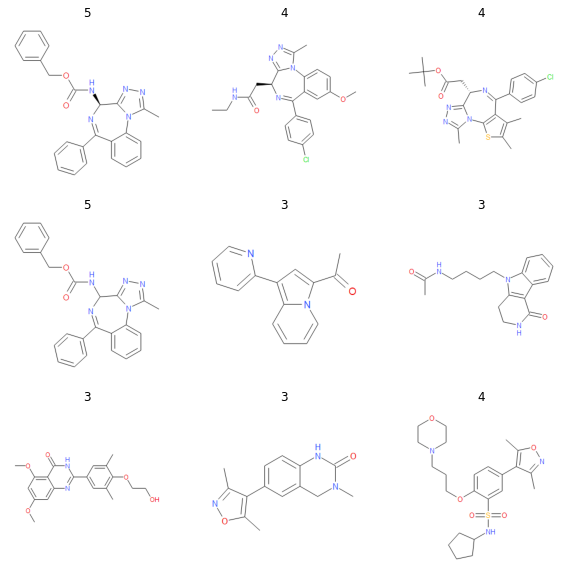

In [9]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(compound_image_data[i])
    plt.title(compound_ring_labels[i])
    plt.axis("off")

We can also inspect the shape of the data to help build our model.

In [10]:
x_train.shape, y_train.shape

((75, 300, 300, 3), (75,))

In [11]:
x_test.shape, y_test.shape

((25, 300, 300, 3), (25,))

In [12]:
mlflow.log_param("training_samples", y_train.shape[0])
mlflow.log_param("holdout_samples", y_test.shape[0])

We have 75 training and 25 test samples, the images are 300 x 300 pixels and have 3 layers.

Let's build and train a demo model.

In [13]:
model = keras.Sequential(
    [
        keras.Input(shape=image_size + (3,)),
        # conv layers 
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5), # Dropout to help reduce overfitting
        layers.Dense(5, activation="softmax"), # 5 output classes 
    ]
)

2021-09-19 10:01:40.719849: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-19 10:01:40.719895: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-19 10:01:40.719924: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ad7d4e63ac63): /proc/driver/nvidia/version does not exist
2021-09-19 10:01:40.720143: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
val_split = 0.2
batch_size = 12
epochs = 15

In [15]:
mlflow.log_param("val_split", val_split)
mlflow.log_param("batch_size", batch_size)
mlflow.log_param("epochs", epochs)

In [16]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train, keras.utils.to_categorical(y_train, num_classes=5), batch_size=batch_size, epochs=epochs, validation_split=0.2)

2021-09-19 10:01:41.003967: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
5/5 [==============================] - 4s 694ms/step - loss: 3465.1567 - accuracy: 0.3000 - val_loss: 3746.8506 - val_accuracy: 0.2667
Epoch 2/15
5/5 [==============================] - 3s 623ms/step - loss: 1327.8340 - accuracy: 0.2333 - val_loss: 262.0274 - val_accuracy: 0.4667
Epoch 3/15
5/5 [==============================] - 3s 618ms/step - loss: 227.6399 - accuracy: 0.2333 - val_loss: 42.1116 - val_accuracy: 0.4667
Epoch 4/15
5/5 [==============================] - 3s 649ms/step - loss: 33.7335 - accuracy: 0.4333 - val_loss: 1.4836 - val_accuracy: 0.1333
Epoch 5/15
5/5 [==============================] - 3s 636ms/step - loss: 1.3882 - accuracy: 0.5667 - val_loss: 1.6268 - val_accuracy: 0.0667
Epoch 6/15
5/5 [==============================] - 3s 647ms/step - loss: 1.4011 - accuracy: 0.4000 - val_loss: 1.4965 - val_accuracy: 0.2667
Epoch 7/15
5/5 [==============================] - 3s 596ms/step - loss: 0.5870 - accuracy: 0.8500 - val_loss: 1.0250 - val_accuracy: 0.6000
Epoch

Additional callbacks could be used to track more suitable metrics for analysis. For this MLOps example, let's keep it basic (it's just a demo!). We can make some plots with the data we have collected and track in MLFlow.

In [17]:
training_df = pd.DataFrame(model.history.history)

In [18]:
for row in training_df.iterrows():
    mlflow.log_metric("loss", row[1]["loss"])
    mlflow.log_metric("val_loss", row[1]["val_loss"])
    mlflow.log_metric("accuracy", row[1]["accuracy"])
    mlflow.log_metric("val_accuracy", row[1]["val_accuracy"])

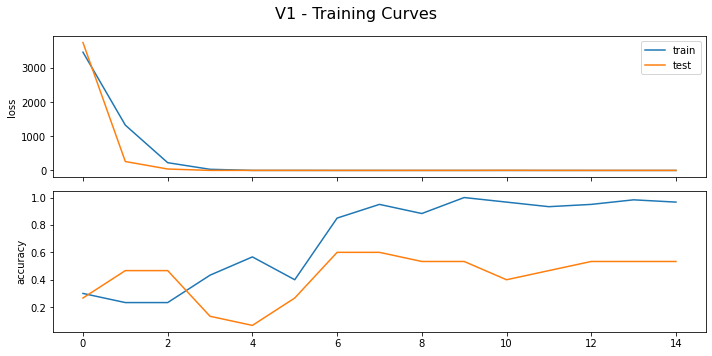

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10, 5))

sns.lineplot(data=training_df, x=training_df.index, y="loss", label="train", ax=ax1)
sns.lineplot(data=training_df, x=training_df.index, y="val_loss", label="test", ax=ax1)

sns.lineplot(data=training_df, x=training_df.index, y="accuracy", ax=ax2)
sns.lineplot(data=training_df, x=training_df.index, y="val_accuracy", ax=ax2)

plt.suptitle("V1 - Training Curves", fontsize=16)
plt.tight_layout()
plt.show()

Let's make some predictions from the holdout set and see the "real world" performance of our model.

In [20]:
y_pred = model.predict(x_test)
y_pred_train = model.predict(x_train)

A confusion matrix is useful for classification tasks.

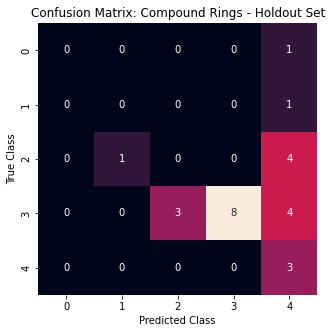

In [21]:
matrix = confusion_matrix(y_test, y_pred.argmax(axis=1))
plt.figure(figsize=(5, 5))
sns.heatmap(matrix, annot=True, cbar=False)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix: Compound Rings - Holdout Set")
plt.show()

In [22]:
clf_rep = classification_report(y_test, y_pred.argmax(axis=1))
print(clf_rep)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         5
           3       1.00      0.53      0.70        15
           4       0.23      1.00      0.38         3

    accuracy                           0.44        25
   macro avg       0.25      0.31      0.21        25
weighted avg       0.63      0.44      0.46        25



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


On the validation set the model seems to be overfit to predicting class 3 (4 rings). As this is a toy example I won't continue with much analysis. Some initial observations;

* (below) we can see the training data output, there is 0 support for class 0 and only 9 for class 1 - more data is required (this would likely have been called out in the scoping phase), never the less we have a benchmark which is better than random
* Class 3 has the highest support and like in the validation set performs well
* In the real world, as well as iterating on data we could look to iterate and improve the model.

In [23]:
print(classification_report(y_train, model.predict(x_train).argmax(axis=1)))

              precision    recall  f1-score   support

           1       0.90      1.00      0.95         9
           2       0.91      0.91      0.91        22
           3       0.93      0.96      0.94        26
           4       0.88      0.78      0.82        18

    accuracy                           0.91        75
   macro avg       0.90      0.91      0.91        75
weighted avg       0.91      0.91      0.91        75



This model isn't great, it is overfit to the train set, but for now let's try and deploy it. We can come back later and improve the model.

In [24]:
mlflow.keras.save_model(model, f"models/{model_version}")

2021-09-19 10:02:34.950525: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/jovyan/data-science/models/v1/data/model/assets


In [25]:
mlflow.end_run()

## V2 
For the purpose of this demo, let's make a second version of the model to simulate some iteration and demostrate the operational side of model promotion.

A typical thing to do in CV tasks in order to increase data is to augment it with transformations of the existing data. Let's take our training set and augment it by making some transformations.

In [26]:
mlflow.start_run(run_name="v2", experiment_id=experiment_id)
model_version = "v2"

In [27]:
mlflow.log_param("version", model_version)
mlflow.log_param("image_size", image_size)

In [28]:
aug_compound_image_data = []
aug_compound_ring_cats = []
aug_compound_ring_labels = []

for row in compound_df.iterrows():
    
    # Save the original 
    original_image = Image.open("data/" + row[1]["image"])
    aug_compound_image_data.append(np.array(original_image))
    aug_compound_ring_labels.append(int(row[1]["num_rings"]))
    aug_compound_ring_cats.append(int(row[1]["num_rings"]) - 1)

    rotations = [90, 180, 270]
    for r in rotations:
        rotated_image = original_image.rotate(r)
        aug_compound_image_data.append(np.array(rotated_image))
        aug_compound_ring_labels.append(int(row[1]["num_rings"]))
        aug_compound_ring_cats.append(int(row[1]["num_rings"]) - 1)
        
aug_compound_image_data = np.array(aug_compound_image_data)
aug_compound_ring_cats = np.array(aug_compound_ring_cats)

In [29]:
x_aug_train, x_aug_test, y_aug_train, y_aug_test = train_test_split(aug_compound_image_data, aug_compound_ring_cats, test_size=0.25, random_state=42)

In [30]:
x_aug_train.shape, y_aug_train.shape

((300, 300, 300, 3), (300,))

In [31]:
x_aug_test.shape, y_aug_test.shape

((100, 300, 300, 3), (100,))

In [32]:
mlflow.log_param("training_samples", y_aug_train.shape[0])
mlflow.log_param("holdout_samples", y_aug_test.shape[0])
mlflow.log_param("val_split", val_split)
mlflow.log_param("batch_size", batch_size)
mlflow.log_param("epochs", epochs)

We now have a bigger data set. This doesn't solve the class distribution problems - in reality the error analysis we performed would have indicated we needed to improve our dataset in certain areas. As this is only a toy example we won't worry too much. Let's train the v2 model.

In [33]:
model.fit(x_aug_train, keras.utils.to_categorical(y_aug_train, num_classes=5), batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/15
20/20 [==============================] - 12s 603ms/step - loss: 1.8188 - accuracy: 0.3750 - val_loss: 1.5915 - val_accuracy: 0.4500
Epoch 2/15
20/20 [==============================] - 12s 598ms/step - loss: 1.5269 - accuracy: 0.4042 - val_loss: 1.5738 - val_accuracy: 0.4333
Epoch 3/15
20/20 [==============================] - 12s 623ms/step - loss: 1.4267 - accuracy: 0.5000 - val_loss: 1.3211 - val_accuracy: 0.4000
Epoch 4/15
20/20 [==============================] - 14s 677ms/step - loss: 1.3188 - accuracy: 0.5042 - val_loss: 1.5721 - val_accuracy: 0.4500
Epoch 5/15
20/20 [==============================] - 14s 697ms/step - loss: 1.4892 - accuracy: 0.4625 - val_loss: 1.5626 - val_accuracy: 0.4500
Epoch 6/15
20/20 [==============================] - 13s 639ms/step - loss: 1.5108 - accuracy: 0.4583 - val_loss: 1.5540 - val_accuracy: 0.4500
Epoch 7/15
20/20 [==============================] - 12s 608ms/step - loss: 1.5035 - accuracy: 0.4583 - val_loss: 1.5465 - val_accuracy: 0.4500

In [34]:
training_df = pd.DataFrame(model.history.history)

In [35]:
for row in training_df.iterrows():
    mlflow.log_metric("loss", row[1]["loss"])
    mlflow.log_metric("val_loss", row[1]["val_loss"])
    mlflow.log_metric("accuracy", row[1]["accuracy"])
    mlflow.log_metric("val_accuracy", row[1]["val_accuracy"])

In [36]:
y_aug_pred = model.predict(x_aug_test)

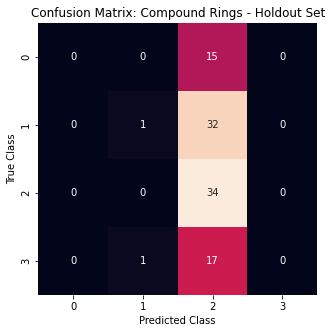

In [37]:
matrix = confusion_matrix(y_aug_test, y_aug_pred.argmax(axis=1))
plt.figure(figsize=(5, 5))
sns.heatmap(matrix, annot=True, cbar=False)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix: Compound Rings - Holdout Set")
plt.show()

In [38]:
clf_rep = classification_report(y_aug_test, y_aug_pred.argmax(axis=1))
print(clf_rep)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        15
           2       0.50      0.03      0.06        33
           3       0.35      1.00      0.52        34
           4       0.00      0.00      0.00        18

    accuracy                           0.35       100
   macro avg       0.21      0.26      0.14       100
weighted avg       0.28      0.35      0.19       100



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
mlflow.keras.save_model(model, f"models/{model_version}")

INFO:tensorflow:Assets written to: /home/jovyan/data-science/models/v2/data/model/assets


Check out the results on MLFLow http://localhost:5000/

We have trained a second model (it is likely terrible!) no further analysis will be undertaken for this demo. The models aren't directly comparable, in the real world we would ensure;
* Holdout data is the same
* Input data has enough support to train the model 
* Put some thought into model architecture and hyperparameters 
* Done some tuning and error analysis 
* Used MLFlow to compare runs 

For now let's return to the API and make some predictions.

In [40]:
mlflow.end_run()